# INTRO

In this python notebook, we analyze the data throught tests. We Try to understand if the the 

In [1]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

from tools_analysis import *

### Definition of input folder

In [2]:
folder_path = "../study"
stats_path = folder_path + "/stats"

# Exploration

# Features names:
```json
metrics = {
    "dti" : ["FA", "AD", "RD", "MD"],
    "noddi" : ["icvf", "odi", "fbundle", "fextra", "fintra", "fiso" ],
    "diamond" : ["wFA", "wMD", "wAD", "wRD", "frac_c0", "frac_c1", "frac_csf", "frac_ctot"],
    "mf" : ["fvf_f0", "fvf_f1", "frac_f0", "fvf_tot", "wfvf", "frac_f1", "frac_csf", "frac_ftot"]
}

masks_name = [
    "thalamus",
    "hippocampus",
    "amygdala",
    "accumbens",
    "putamen",
    "pallidum",

    "antThalRadiation",
    "postThalRadiation-parital",
    "postThalRadiation-occipital",
    "supThalRadiation",
    "infThalRadiation-insula",
    "infThalRadiation-temporal",
    "sup-longi-fasci",
    "inf-longi-fasci",
    "fornix",

    "acomm",
    "cc.bodyc",
    "cc.bodyp",
    "cc.bodypf",
    "cc.bodypm",
    "cc.bodyt",
    "cc.genu",
    "cc.rostrum",
    "cc.splenium",
    "lh.af",
    "lh.ar",
    "lh.atr",
    "lh.cbd",
    "lh.cbv",
    "lh.cst",
    "lh.emc",
    "lh.fat",
    "lh.fx",
    "lh.ilf",
    "lh.mlf",
    "lh.or",
    "lh.slf1",
    "lh.slf2",
    "lh.slf3",
    "lh.uf",
    "mcp",
    "lh.af",
    "rh.ar",
    "rh.atr",
    "rh.cbd",
    "rh.cbv",
    "rh.cst",
    "rh.emc",
    "rh.fat",
    "rh.fx",
    "rh.ilf",
    "rh.mlf",
    "rh.or",
    "rh.slf1",
    "rh.slf2",
    "rh.slf3",
    "rh.uf",
    "mcp"

]
```

They are composed in the following manner:

[right|left]-[mask_name]\_[metrics]\_[mean|std|skew|kurt|min|max]

[right|left]-[roi_name]\_voxVol

[right|left]-[roiTract_name]\_nTracts


In [85]:
metrics = ["FA", "AD", "RD", "MD", "icvf", "odi", "fbundle", "fextra", "fintra", "fiso", "wFA", "wMD", "wAD", "wRD", "frac_c0", "frac_c1", "frac_csf", "frac_ctot", "fvf_f0", "fvf_f1", "frac_f0", "fvf_tot", "wfvf", "frac_f1", "frac_csf", "frac_ftot"]


masks_name = [
    "thalamus",
    "hippocampus",
    "amygdala",
    "accumbens",
    "putamen",
    "pallidum",

    "antThalRadiation",
    "postThalRadiation-parital",
    "postThalRadiation-occipital",
    "supThalRadiation",
    "infThalRadiation-insula",
    "infThalRadiation-temporal",
    "sup-longi-fasci",
    "inf-longi-fasci",
    "fornix",

    "acomm",
    "cc.bodyc",
    "cc.bodyp",
    "cc.bodypf",
    "cc.bodypm",
    "cc.bodyt",
    "cc.genu",
    "cc.rostrum",
    "cc.splenium",
    "lh.af",
    "lh.ar",
    "lh.atr",
    "lh.cbd",
    "lh.cbv",
    "lh.cst",
    "lh.emc",
    "lh.fat",
    "lh.fx",
    "lh.ilf",
    "lh.mlf",
    "lh.or",
    "lh.slf1",
    "lh.slf2",
    "lh.slf3",
    "lh.uf",
    "mcp",
    "lh.af",
    "rh.ar",
    "rh.atr",
    "rh.cbd",
    "rh.cbv",
    "rh.cst",
    "rh.emc",
    "rh.fat",
    "rh.fx",
    "rh.ilf",
    "rh.mlf",
    "rh.or",
    "rh.slf1",
    "rh.slf2",
    "rh.slf3",
    "rh.uf",
    "mcp"

]

Here the explanation of some features:

NR-RP/R:

- NR-RP/R == 0 => Non Responder
- NR-RP/R == 1 => Partial responder or Responder

NR-RP-R:

- NR-RP-R == 0 => Non Responder
- NR-RP-R == 1 => Partial Responder
- NR-RP-R == 2 => Responder

epilepsy_type:

- epilepsy_type == 1 => Generalized
- epilepsy_type == 2 => Focal

AEDs := Anti Epileptic Drugs

# Analysis on only epileptic patiens without personal data

In [141]:
# Reading the whole dataset
df = pd.read_csv("%s/dataset.csv" % stats_path, index_col="ID")
print(df.shape)
# # Removing the healty subjects
# df.dropna(axis=0, how="any", inplace=True) 
# print(df.shape)

info = df.columns[:10]
df[info] = df[info].astype(int)

df = df.drop("VNSLC_16") # remove it because doesn't have the tracts from freesurfer
df = df.dropna(axis=1) # remove NaN features
df = df.drop(df.filter(regex=r'(min|max)'), axis=1) # remove max and min features because are full of imperfections
df = df.drop(df.filter(regex=r'(kurt|nTracts)'), axis=1) # remove them beacuse they have an high variability and difficult to interpretare (only kurt)
df = df.loc[:, (abs(df - df.iloc[0]) > 1e-12).any()] # Removing almost constant features
print(df.shape)

(19, 11272)
(18, 5560)


Drop the VNLSC_16 subjects and the nan features right cbv, because they are null in the VNSLC_19 subj.

In [142]:
print(df.value_counts("resp"))
print(df.value_counts("respPart"))

resp
1    11
0     7
Name: count, dtype: int64
respPart
0    7
2    7
1    4
Name: count, dtype: int64


In our case we have few examples (patients), and so the model will not be so accurate. Then the difference between patients responders and not is different, so our model will be bias influenced.

While if we see the number of samples between responders, partial and not, the number of samples for each class is almost equilibrate.

Here we want to find which is the best scaling approach, we use a stratified shuffle split to create 100 train and test sets.
We'll use them to approximate the score of a Logistic regression model. (A basic model for binarized classification task)
To 

We need to tune the regularization term alpha for the Logistic Regression model. We achive this by using the Logistic RegressionCV by sklear

# Analysis of info data

- Age = Epilepsy onset age + Epilepsy duration
  

In [143]:
df.age == df.epilepsy_onset_age + df.epilepsy_duration

ID
VNSLC_01     True
VNSLC_02     True
VNSLC_03     True
VNSLC_04     True
VNSLC_06     True
VNSLC_07     True
VNSLC_09     True
VNSLC_10     True
VNSLC_11     True
VNSLC_12     True
VNSLC_13     True
VNSLC_14     True
VNSLC_15     True
VNSLC_17     True
VNSLC_18     True
VNSLC_19    False
VNSLC_22    False
VNSLC_23    False
dtype: bool

There is a problem in the last three subjects, the sum isn't equal to the age.

Since Age is a compose variable it doens't give any informations for the classification between responder and not.

# Scaling

In [233]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer 
from sklearn.model_selection import StratifiedShuffleSplit

for scaler in [None, StandardScaler(), MinMaxScaler(), Normalizer("l1"), Normalizer("l2"), RobustScaler()]:
    print(scaler.__class__.__name__)
    
    run_log_reg_cv(
        df.filter(regex=r'mean|std|skew|voxVol|age|duration'), 
        df["resp"],
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=scaler,
        )


NoneType
F1: 0.085 | Pr: 0.670 | Re: 0.999 | AUC: 0.492 | Accuracy: 0.352 

StandardScaler
F1: 0.427 | Pr: 0.749 | Re: 0.956 | AUC: 0.663 | Accuracy: 0.500 

MinMaxScaler
F1: 0.147 | Pr: 0.678 | Re: 1.000 | AUC: 0.489 | Accuracy: 0.369 

Normalizer
F1: 0.704 | Pr: 0.741 | Re: 0.990 | AUC: 0.470 | Accuracy: 0.581 

Normalizer
F1: 0.707 | Pr: 0.743 | Re: 0.991 | AUC: 0.477 | Accuracy: 0.584 

RobustScaler
F1: 0.342 | Pr: 0.718 | Re: 0.984 | AUC: 0.576 | Accuracy: 0.444 



The best are:
- Normalizer: for F1-score and accuracy
- Standard Scaler:  for AUC

##### F1 Score
F1 score (also known as F-measure, or balanced F-score) is an error metric whose score ranges from 0 to 1, where 0 is the worst and 1 is the best possible score. It provides robust results for imbalanced datasets and evaluates both the recall and precision ability of the model.

##### AUC
The score it produces ranges from 0.5 to 1 where 1 is the best score and 0.5 means the model is as good as random.
The area under this ROC curve, AUC, therefore equates to the model’s ability to predict classes correctly, as a large amount of area would show that the model can achieve a high true positive rate with a correspondingly low false positive rate.

##### AUC vs F1
AUC does not perform well on imbalanced datasets which often leads to misleading results, whilst F1 is still able to measure performance objectively when the class balance is skewed.

F1 should be used for situations when you either have an imbalanced dataset or you need to communicate your results to end users, due to the relatively simple definition of F1 in comparison with AUC. AUC should be used when you have a balanced dataset or you don’t want to set a probability boundary between classes, which is required for F1.


In [236]:
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler

# Normalized
X_scaled = df.filter(regex=r'mean|std|skew|voxVol|age|duration') # Take only the contineus value
index, columns = X_scaled.index, X_scaled.columns
scaler = Normalizer()
X_scaled = scaler.fit_transform(X_scaled)
X = pd.DataFrame(X_scaled, index=index, columns=columns)
df_normalized = pd.concat([df["resp"], df["respPart"], X], axis=1)

# Standard Scaler
X_scaled = df.filter(regex=r'mean|std|skew|voxVol|age|duration') # Take only the contineus value
index, columns = X_scaled.index, X_scaled.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_scaled)
X = pd.DataFrame(X_scaled, index=index, columns=columns)
df_standardized = pd.concat([df["resp"], df["respPart"], X], axis=1)

# Robust Scaler
X_scaled = df.filter(regex=r'mean|std|skew|voxVol|age|duration') # Take only the contineus value
index, columns = X_scaled.index, X_scaled.columns
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_scaled)
X = pd.DataFrame(X_scaled, index=index, columns=columns)
df_robusted = pd.concat([df["resp"], df["respPart"], X], axis=1)

# Tuning C parameter for LogReg Estimation

In [238]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit

col_int = df.filter(regex=r'mean|std|skew|voxVol|age|duration').columns

logReg = LogisticRegressionCV(
    Cs=20,
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
    dual=True, # Good if we have few samples
    penalty="l2",
    solver="liblinear",
    max_iter=100000,
    n_jobs=-1,
    scoring="f1", # change it
)
logReg.fit(df[col_int], df["resp"])

for c, score in zip(logReg.Cs_, logReg.scores_[1].mean(axis=0)):
    print(c, "\t", score)

/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/michele/anaconda3/envs/dMRI/lib/python3

KeyboardInterrupt: 

After trying f1, roc_auc and accracy the best C is 0.00183

In [139]:
1/(0.0001*df.shape[0])

555.5555555555555

In [237]:
run_log_reg_cv(
        df_robusted.filter(regex=r'mean|std|skew|voxVol|age|duration'), 
        df["resp"],
        StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
        pipeline=None
        )

F1: 0.501 | Pr: 0.722 | Re: 0.967 | AUC: 0.605 | Accuracy: 0.511 



SGDClassifier(loss='log_loss', n_jobs=-1)

# Statistical Test 

## Relationship between sex and being responder

Explanation here: <br>
https://machinelearningmastery.com/chi-squared-test-for-machine-learning/ <br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html <br>
https://www.scribbr.com/statistics/chi-square-test-of-independence/

Is there a relationship between sex and being respoders?

We use a chi square test since both features are categorical.

First we have to put the two variable in a **Contingency table** between them.

The **Chi-Squared test** is a statistical hypothesis test that assumes (the null hypothesis) that *the observed frequencies for a categorical variable match the expected frequencies for the categorical variable*.

The variables are considered **independent** if *the observed and expected frequencies are similar*, that the levels of the variables do not interact, are not dependent.

```
degrees of freedom: (rows - 1) * (cols - 1)
```

- **If Statistic >= Critical Value**: significant result, reject null hypothesis (H0), *dependent*.
- **If Statistic < Critical Value**: not significant result, fail to reject null hypothesis (H0), *independent*.
  
Or in terms of p-value

- **If p-value <= alpha**: significant result, reject null hypothesis (H0), *dependent*.
- **If p-value > alpha**: not significant result, fail to reject null hypothesis (H0), *independent*.

For the test to be effective, at **least five observations are required in each cell of the contingency table**, otherwise exact tests (such as **Barnard’s Exact test**) should be used because they do not overreject.

The test is only meaningful when **the dimension of observed is two or more**.

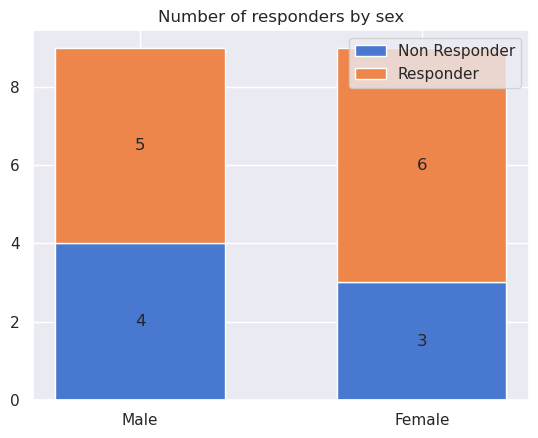

In [19]:
sexs = ("Male", "Female")
resps = ("Non Responder", "Responder")
width = 0.6

fig, ax = plt.subplots()
bottom = np.zeros(2)

M = pd.crosstab(index=df["resp"], columns=df["sex"]).to_numpy()

for resp_idx, resp in enumerate(resps):

    p = ax.bar(sexs, M[resp_idx, :], width, label=resp, bottom=bottom)
    bottom += M[resp_idx, :]

    ax.bar_label(p, label_type="center")

ax.set_title("Number of responders by sex")
ax.legend()

plt.show()

### Hypotesis definition

From:<br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.barnard_exact.html#scipy.stats.barnard_exact

Null hypotesis: no difference between female and male of becoming non responders to VNS
Alternative hypothesis: female have lower chance of becoming non responders to VNS

probability $p_1$ of being non responder being male will be *greater* than the probability $p_2$ of being non responder being female. (This information can be get even from the graph, because the number of non responderes in males is grather than the female)

### Table organization

From the definition:<br>
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.barnard_exact.html#scipy.stats.barnard_exact

In the row should be the output variable (being responder or not), in the columns the input variables (in this case the sex).

In [30]:
from scipy import stats

def printRes(a, p, method):
    print('significance=%.3f, p=%.3f' % (a, p))
    if p <= a:
        print(method+": Dependent")
    else:
        print(method+": Independent")

alpha = 0.05
obs = pd.crosstab(index=df["resp"], columns=df["sex"])
obs.index = ("nonResp", "Resp")
obs.columns = ("male", "female")
print(obs)
print()

# Chi squared
statistic, p_val, dof, exp_freq = stats.chi2_contingency(obs, True)
printRes(alpha, p_val, "Chi2")

# Barnard Exact
res = stats.barnard_exact(obs, alternative="greater")
printRes(alpha, res.pvalue, "Barnard")

# Fisher Exact
res = stats.fisher_exact(obs, alternative="greater")
printRes(alpha, res.pvalue, "Fisher")

         male  female
nonResp     4       3
Resp        5       6

significance=0.050, p=1.000
Chi2: Independent
significance=0.050, p=0.387
Barnard: Independent
significance=0.050, p=0.500
Fisher: Independent


The null hypotesis in not rejected: beeing male doesn't have a greater probability to be non responder

## Relationship between benzo and being responder

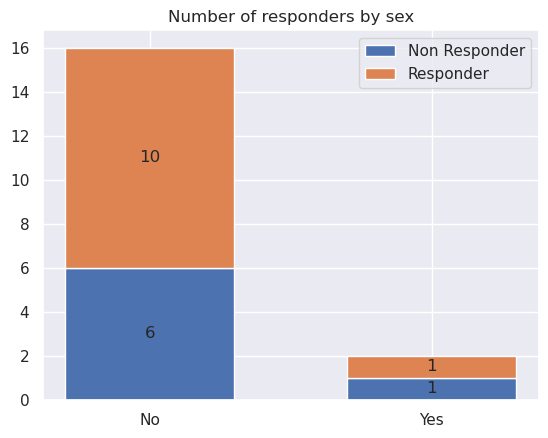

In [64]:
cat = ("No", "Yes")
resps = ("Non Responder", "Responder")
width = 0.6

fig, ax = plt.subplots()
bottom = np.zeros(2)

M = pd.crosstab(index=df["resp"], columns=df["benzo"]).to_numpy()

for resp_idx, resp in enumerate(resps):

    p = ax.bar(cat, M[resp_idx, :], width, label=resp, bottom=bottom)
    bottom += M[resp_idx, :]

    ax.bar_label(p, label_type="center")

ax.set_title("Number of responders by sex")
ax.legend()

plt.show()

The Alternative hypotesis here will be (from the barplot) that not taking benzo have *less* probability to be non responder.

In [65]:
from scipy import stats

def printRes(a, p, method):
    print('significance=%.3f, p=%.3f' % (a, p))
    if p <= a:
        print(method+": Dependent")
    else:
        print(method+": Independent")

alpha = 0.05
obs = pd.crosstab(index=df["resp"], columns=df["benzo"])
obs.index = ("nonResp", "Resp")
obs.columns = ("no", "yes")
print(obs)
print()

# Chi squared
statistic, p_val, dof, exp_freq = stats.chi2_contingency(obs, True)
printRes(alpha, p_val, "Chi2")

# Barnard Exact
res = stats.barnard_exact(obs, alternative="less")
printRes(alpha, res.pvalue, "Barnard")

# Fisher Exact
res = stats.fisher_exact(obs, alternative="less")
printRes(alpha, res.pvalue, "Fisher")


         no  yes
nonResp   6    1
Resp     10    1

significance=0.050, p=1.000
Chi2: Independent
significance=0.050, p=0.675
Barnard: Independent
significance=0.050, p=0.641
Fisher: Independent


Our alternative hypotesis is rejected

## Relationship between the type of epilespy and being responder

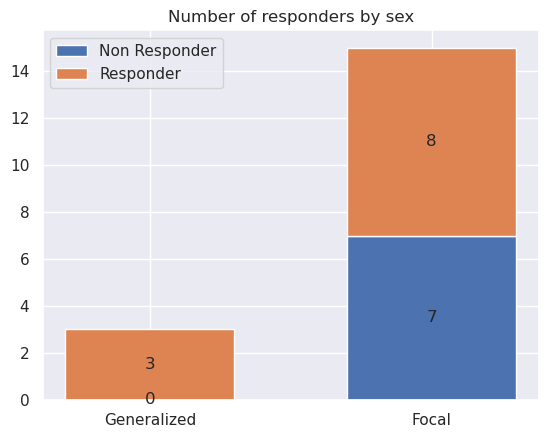

In [66]:
cat = ("Generalized", "Focal")
resps = ("Non Responder", "Responder")
width = 0.6

fig, ax = plt.subplots()
bottom = np.zeros(2)

M = pd.crosstab(index=df["resp"], columns=df["epilepsy_type"]).to_numpy()

for resp_idx, resp in enumerate(resps):

    p = ax.bar(cat, M[resp_idx, :], width, label=resp, bottom=bottom)
    bottom += M[resp_idx, :]

    ax.bar_label(p, label_type="center")

ax.set_title("Number of responders by sex")
ax.legend()

plt.show()

From the boxplot the alternative hypotesis will be that who has a generalized Epilepsy have *less* probability to be a non responder

In [67]:
from scipy import stats

def printRes(a, p, method):
    print('significance=%.3f, p=%.3f' % (a, p))
    if p <= a:
        print(method+": Dependent")
    else:
        print(method+": Independent")

alpha = 0.05
obs = pd.crosstab(index=df["resp"], columns=df["epilepsy_type"])
obs.index = ("nonResp", "Resp")
obs.columns = ("Generalized", "Focal")
print(obs)
print()

# Chi squared
statistic, p_val, dof, exp_freq = stats.chi2_contingency(obs, True)
printRes(alpha, p_val, "Chi2")

# Barnard Exact
res = stats.barnard_exact(obs, alternative="less")
printRes(alpha, res.pvalue, "Barnard")

# Fisher Exact
res = stats.fisher_exact(obs, alternative="less")
printRes(alpha, res.pvalue, "Fisher")

         Generalized  Focal
nonResp            0      7
Resp               3      8

significance=0.050, p=0.387
Chi2: Independent
significance=0.050, p=0.095
Barnard: Independent
significance=0.050, p=0.202
Fisher: Independent


Our alternative hypotesis is rejected

## Logistic Regression Relationship between Quantitative data and Categorical

### Age

/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, 

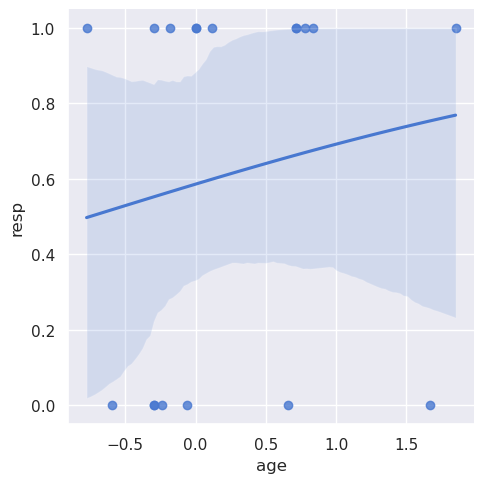

In [44]:
sns.lmplot(data=df, x="age", y="resp", logistic=True)

### Therapy duration

/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, 

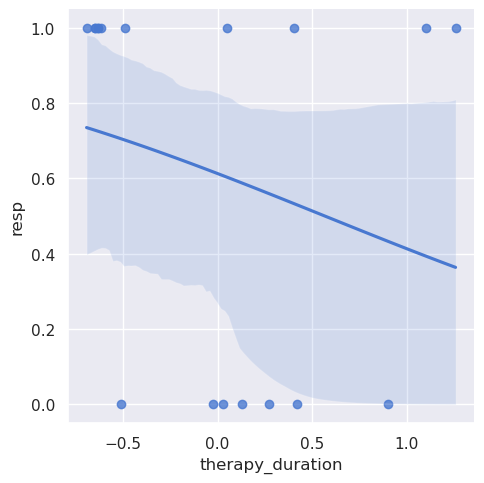

In [43]:
sns.lmplot(data=df, x="therapy_duration", y="resp", logistic=True)

### Onset Age


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)


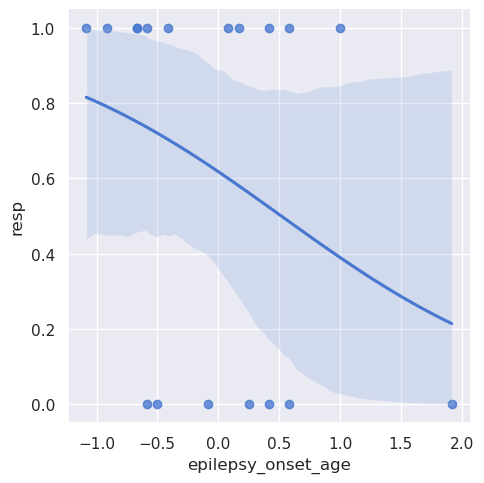

In [45]:
sns.lmplot(data=df, x="epilepsy_onset_age", y="resp", logistic=True)

### Epilepsy Duration

/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:1257: PerfectSeparationWarning: Perfect separation or prediction detected, 

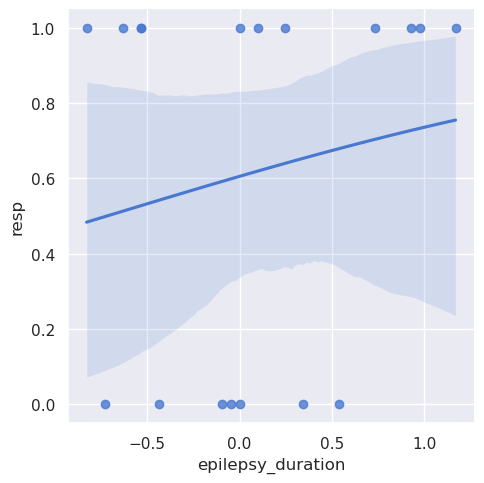

In [46]:
sns.lmplot(data=df, x="epilepsy_duration", y="resp", logistic=True)

## Relation between variables that should be similar

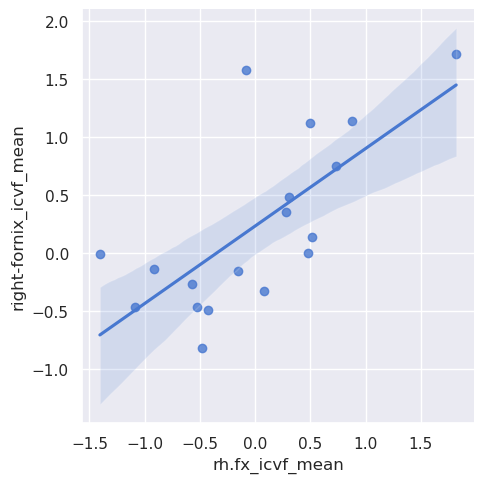

In [49]:
sns.lmplot(data=df, x="rh.fx_icvf_mean", y="right-fornix_icvf_mean", robust=False)

<Axes: xlabel='rh.fx_icvf_mean', ylabel='right-fornix_icvf_mean'>

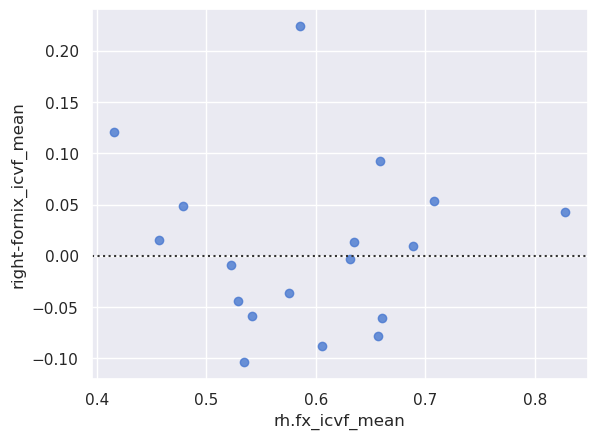

In [43]:
sns.residplot(data=df, x="rh.fx_icvf_mean", y="right-fornix_icvf_mean", robust=True)

## Comparison Test

<Axes: xlabel='resp', ylabel='cc.bodypf_FA_mean'>

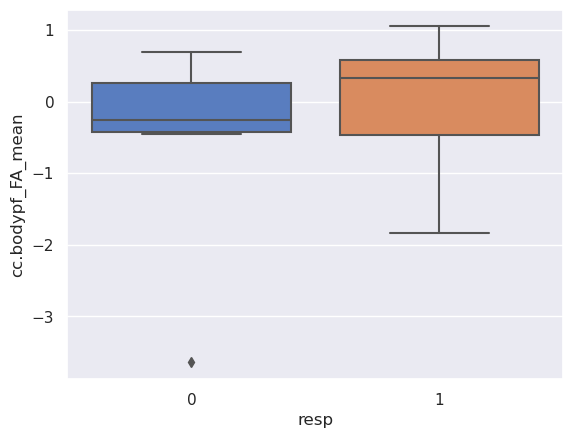

In [26]:
sns.boxplot(df, y="cc.bodypf_FA_mean", x="resp")

In [54]:
print(df["lh.slf1_RD_skew"][df["resp"] == 0].var())
print(df["lh.slf1_RD_skew"][df["resp"] == 1].var())

0.0853714223924739
0.39365999337862795


In [55]:
from scipy.stats import ttest_ind

noResp = df["right-fornix_icvf_mean"][df["resp"] == 0]
resp = df["right-fornix_icvf_mean"][df["resp"] == 1]

ttest_ind(noResp, resp, equal_var=False, alternative="two-sided")

Ttest_indResult(statistic=-3.3130529546905874, pvalue=0.004881382367146485)

In [56]:
from scipy.stats import mannwhitneyu

noResp = df["right-fornix_icvf_mean"][df["resp"] == 0]
resp = df["right-fornix_icvf_mean"][df["resp"] == 1]

mannwhitneyu(noResp, resp, alternative="two-sided", method="auto")

MannwhitneyuResult(statistic=12.0, pvalue=0.015397184514831573)

<Axes: xlabel='respPart', ylabel='rh.fx_icvf_mean'>

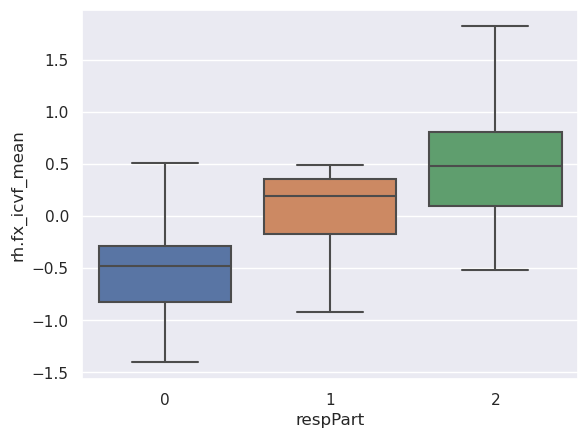

In [72]:
sns.boxplot(df, y="rh.fx_icvf_mean", x="respPart")

In [73]:
from scipy.stats import f_oneway

noResp = df["right-fornix_icvf_mean"][df["respPart"] == 0]
respPart = df["right-fornix_icvf_mean"][df["respPart"] == 1]
resp = df["right-fornix_icvf_mean"][df["respPart"] == 2]

f_oneway(noResp, respPart, resp)

F_onewayResult(statistic=4.660372488541751, pvalue=0.026659861519565568)

In [50]:
from scipy.stats import kruskal

noResp = df["right-fornix_icvf_mean"][df["respPart"] == 0]
respPart = df["right-fornix_icvf_mean"][df["respPart"] == 1]
resp = df["right-fornix_icvf_mean"][df["respPart"] == 2]

kruskal(noResp, respPart, resp)

KruskalResult(statistic=6.367167919799499, pvalue=0.041436880561090655)

# Comparisons of best region with [METRIC] that has a good separation between responders and not

For each tract we find the one that has the best FA that can divide the responders from the non responders

In [217]:
import scipy
from scipy.stats import mannwhitneyu, ttest_ind, shapiro
from outliers import smirnov_grubbs as grubbs

X = df_normalized

def f_test(group1, group2):
    if np.var(group1, ddof=1) >= np.var(group2, ddof=1):
        x = np.array(group1)
        y = np.array(group2)
    else:
        x = np.array(group2)
        y = np.array(group1)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) # calculate F test statistic
    nun = x.size-1 # define degrees of freedom numerator
    dun = y.size-1 # define degrees of freedom denominator
    p_value = 1-scipy.stats.f.cdf(f, nun, dun) # find p-value of F test statistic
    return f, p_value

def countOutliers(group):
    x = np.array(group)
    q1 = np.quantile(x, 0.25)
    q3 = np.quantile(x, 0.75)
    iqr = q3 - q1
    upper = q3 + 1.5*iqr
    lower = q1 - 1.5*iqr

    nOutliers = 0
    nOutliers += (x > upper).sum()
    nOutliers += (x < lower).sum()

    return nOutliers

pval_thresh = 0.05

noResp = X[X["resp"] == 0]
resp = X[X["resp"] == 1]

res = {}

for mask in masks_name:
    features = X.filter(regex=f"{mask}").columns
    res[mask] = {}
    for alt in ["two-sided", "less", "greater"]:

        # Checks for parametric test
        ## shapiro null hypotheis that the data was drawn from a normal distribution
        p_vals_shap_nonR = {col: shapiro(noResp[col]).pvalue for col in features}
        p_vals_shap_R = {col: shapiro(resp[col]).pvalue for col in features}
        ## f-test null hypothesis that the data has the same variance
        p_vals_ftest =  {col: f_test(noResp[col], resp[col])[1] for col in features}
        ## Grubbs' test for outliers
        bool_grubbs_nonR = {col: countOutliers(noResp[col]) > 0 for col in features}
        bool_grubbs_R = {col: countOutliers(resp[col]) > 0 for col in features}
        ## Check all the conditions for the parametric assumptions
        isParametric = {col: True if p_vals_shap_nonR[col]>=pval_thresh and p_vals_shap_R[col]>=pval_thresh and p_vals_ftest[col]>=pval_thresh and bool_grubbs_nonR[col] == False and bool_grubbs_R[col] == False else False for col in features}

        # Compute the relative test depending the assumptions
        p_vals = {col+"-ttest" if isParametric[col] else col+"-mannwhitneyu": ttest_ind(noResp[col], resp[col], equal_var=False, alternative=alt).pvalue if isParametric[col] else mannwhitneyu(noResp[col], resp[col], alternative=alt, method="auto").pvalue for col in features}
        p_vals = {k:v for k, v in sorted(p_vals.items(), key=lambda x: x[1]) if v <= pval_thresh}

        res[mask][alt] = set(p_vals.keys())

In [213]:
X = df_normalized

features = X.filter(regex=r'mean|std|skew|voxVol|age|duration')
noResp = X[X["resp"] == 0]
resp = X[X["resp"] == 1]

p_vals_shap_nonR = {col: shapiro(noResp[col]).pvalue for col in features}
p_vals_shap_R = {col: shapiro(resp[col]).pvalue for col in features}
## f-test null hypothesis that the data has the same variance
p_vals_ftest =  {col: f_test(noResp[col], resp[col])[1] for col in features}
## Grubbs' test for outliers
bool_grubbs_nonR = {col: countOutliers(noResp[col]) > 0 for col in features}
bool_grubbs_R = {col: countOutliers(resp[col]) > 0 for col in features}

nParametrics = 0
for col in features:
    if p_vals_shap_nonR[col]>=pval_thresh and p_vals_shap_R[col]>=pval_thresh and p_vals_ftest[col]>=pval_thresh and bool_grubbs_nonR[col] == False and bool_grubbs_R[col] == False:
        nParametrics += 1

print(nParametrics)

1762


none: 1634

robust: 1634

standard: 1634

normalize: 1762

In [218]:
res

{'thalamus': {'two-sided': {'left-thalamus_AD_mean-mannwhitneyu',
   'left-thalamus_MD_mean-mannwhitneyu',
   'left-thalamus_MD_std-mannwhitneyu',
   'left-thalamus_RD_mean-mannwhitneyu',
   'left-thalamus_RD_std-mannwhitneyu',
   'left-thalamus_fintra_skew-mannwhitneyu',
   'left-thalamus_icvf_skew-mannwhitneyu',
   'left-thalamus_odi_skew-ttest',
   'right-thalamus_MD_std-mannwhitneyu',
   'right-thalamus_RD_std-mannwhitneyu',
   'right-thalamus_fextra_mean-mannwhitneyu',
   'right-thalamus_icvf_skew-mannwhitneyu',
   'right-thalamus_wFA_skew-mannwhitneyu',
   'right-thalamus_wMD_skew-mannwhitneyu'},
  'less': {'left-thalamus_fextra_skew-ttest',
   'right-thalamus_wFA_skew-mannwhitneyu',
   'right-thalamus_wMD_skew-mannwhitneyu'},
  'greater': {'left-thalamus_AD_mean-mannwhitneyu',
   'left-thalamus_MD_mean-mannwhitneyu',
   'left-thalamus_MD_std-mannwhitneyu',
   'left-thalamus_RD_mean-mannwhitneyu',
   'left-thalamus_RD_std-mannwhitneyu',
   'left-thalamus_fintra_skew-mannwhitneyu'

In [27]:
features = df.filter(regex=r'amygdala').columns
alt = "two-sided"

In [31]:
from scipy.stats import mannwhitneyu

pval_thresh = 0.05

noResp = df[df["resp"] == 0]
resp = df[df["resp"] == 1]

p_vals = {col: mannwhitneyu(noResp[col], resp[col], alternative=alt, method="auto").pvalue for col in features}

p_vals = {k:v for k, v in sorted(p_vals.items(), key=lambda x: x[1]) if v <= pval_thresh}
p_vals

{'right-amygdala_RD_skew': 0.015397184514831573,
 'left-amygdala_MD_mean': 0.02042483660130719,
 'left-amygdala_RD_mean': 0.02042483660130719,
 'left-amygdala_AD_mean': 0.026772247360482657,
 'left-amygdala_wFA_mean': 0.03456510809451986,
 'left-amygdala_wfvf_skew': 0.03456510809451986,
 'left-amygdala_FA_mean': 0.04411764705882353,
 'right-amygdala_AD_std': 0.04411764705882353}

In [32]:
from scipy.stats import ttest_ind

pval_thresh = 0.05

noResp = df[df["resp"] == 0]
resp = df[df["resp"] == 1]

p_vals = {col: ttest_ind(noResp[col], resp[col], equal_var=False, alternative=alt).pvalue for col in features}

p_vals = {k:v for k, v in sorted(p_vals.items(), key=lambda x: x[1]) if v <= pval_thresh}
p_vals

{'right-amygdala_RD_skew': 0.024072461599452376,
 'right-amygdala_wRD_skew': 0.027053454819430056,
 'left-amygdala_wFA_mean': 0.02900086191896005,
 'left-amygdala_RD_mean': 0.04040772831044827,
 'left-amygdala_MD_mean': 0.0423904875249251,
 'right-amygdala_wMD_skew': 0.04876283456487818}

In [9]:
from scipy.stats import f_oneway

features = df.columns
pval_thresh = 0.05

noResp = df[df["respPart"] == 0]
respPart = df[df["respPart"] == 1]
resp = df[df["respPart"] == 2]

p_vals = {col: f_oneway(noResp[col], respPart[col], resp[col]).pvalue for col in features}

p_vals = {k:v for k, v in sorted(p_vals.items(), key=lambda x: x[1]) if v <= pval_thresh}
p_vals

/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


{'resp': 0.0,
 'respPart': 0.0,
 'lh.fx_icvf_skew': 0.0002699133744376709,
 'right-fornix_RD_mean': 0.0008508033822484957,
 'lh.slf3_frac_csf_mf_std': 0.0010316591184765685,
 'lh.slf3_frac_ftot_std': 0.0010316591184765685,
 'cc.bodypf_odi_skew': 0.0015965117865141805,
 'left-fornix_RD_mean': 0.0018366926684175576,
 'right-fornix_MD_mean': 0.002858886976033674,
 'left-accumbens-area_frac_c1_std': 0.00324233939297154,
 'left-antThalRadiation_frac_f1_mean': 0.003411808174494416,
 'left-pallidum_icvf_std': 0.0036654887899183813,
 'left-putamen_frac_csf_mf_std': 0.0039628685641786,
 'left-putamen_frac_ftot_std': 0.0039628685641786,
 'rh.emc_AD_mean': 0.0040519573028207165,
 'right-inf-longi-fasci_odi_std': 0.0043260967288880885,
 'right-antThalRadiation_fextra_std': 0.0043586055421885464,
 'left-fornix_MD_mean': 0.0045132087943020645,
 'lh.slf1_RD_skew': 0.004966054905029886,
 'right-putamen_RD_mean': 0.004966961533793896,
 'right-putamen_MD_mean': 0.00612883136627113,
 'right-putamen_frac_

In [126]:
from scipy.stats import kruskal

features = df.columns
pval_thresh = 0.05

noResp = df[df["respPart"] == 0]
respPart = df[df["respPart"] == 1]
resp = df[df["respPart"] == 2]

p_vals = {col: kruskal(noResp[col], respPart[col], resp[col]).pvalue for col in features}

p_vals = {k:v for k, v in sorted(p_vals.items(), key=lambda x: x[1]) if v <= pval_thresh}
p_vals

{'respPart': 0.00020346836901064455,
 'resp': 0.00020346836901064563,
 'lh.fx_icvf_skew': 0.002506866268390786,
 'lh.slf1_RD_skew': 0.0030711159379943733,
 'lh.cst_odi_std': 0.0031196011392614345,
 'left-pallidum_fextra_std': 0.0034986137121953893,
 'right-inf-longi-fasci_odi_std': 0.0036258222621360662,
 'right-fornix_RD_mean': 0.00422211730225809,
 'right-putamen_wFA_std': 0.005124053141987317,
 'left-pallidum_icvf_std': 0.005646656215278148,
 'cc.bodypf_odi_skew': 0.006137373506640009,
 'right-fornix_MD_mean': 0.006137373506640009,
 'left-accumbens-area_wFA_std': 0.006987313384752869,
 'left-fornix_MD_mean': 0.007254994411756581,
 'left-fornix_RD_mean': 0.007254994411756581,
 'left-putamen_frac_csf_mf_std': 0.0074765040074278,
 'left-putamen_frac_ftot_std': 0.0074765040074278,
 'left-antThalRadiation_frac_f1_mean': 0.007575529112428889,
 'rh.cbd_frac_csf_mf_mean': 0.008369107591561977,
 'rh.cbd_frac_ftot_mean': 0.008369107591561977,
 'rh.ar_AD_std': 0.00888796073765363,
 'right-pall

# Simple Exploratory Data Analysis

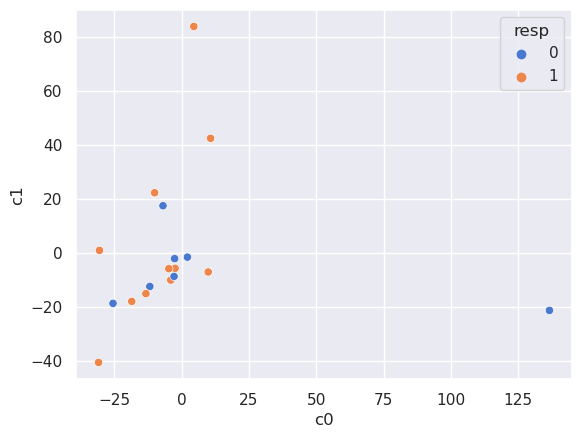

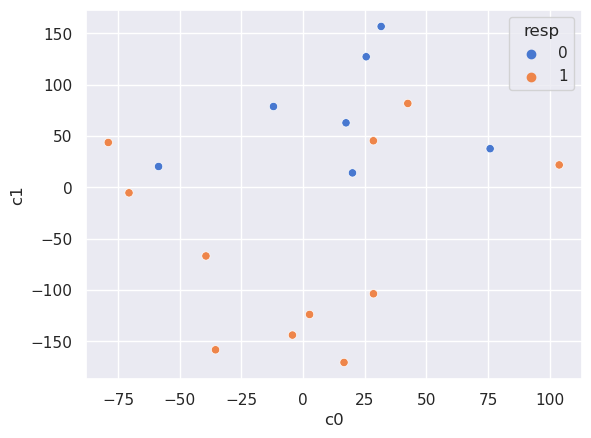

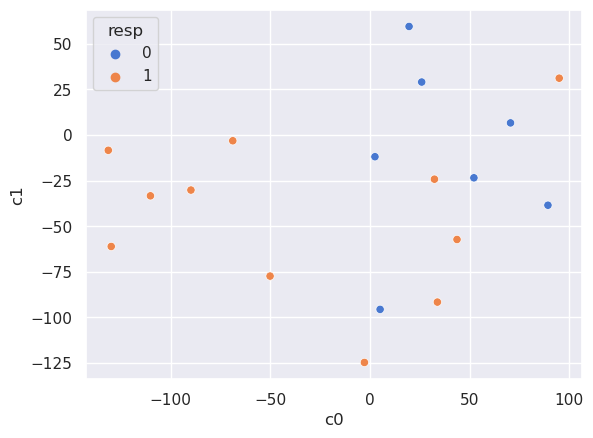

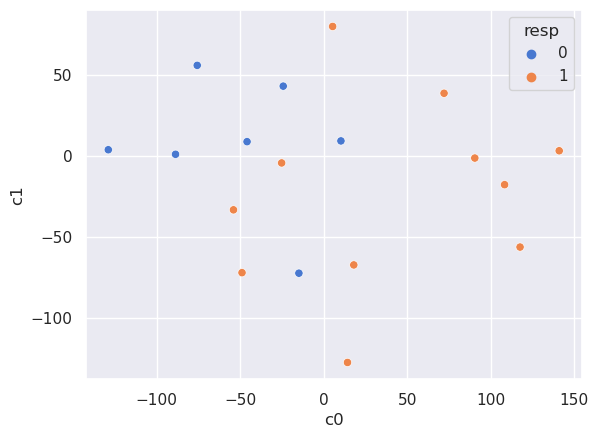

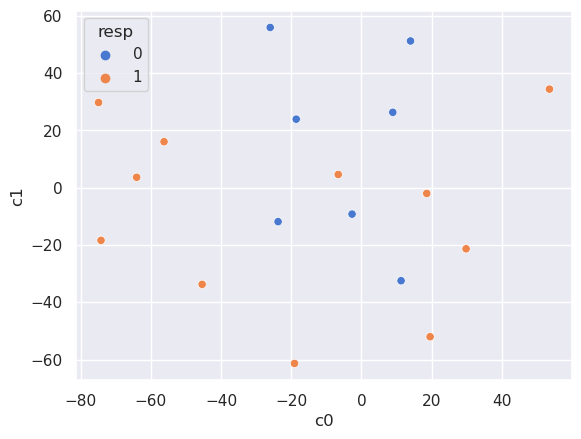

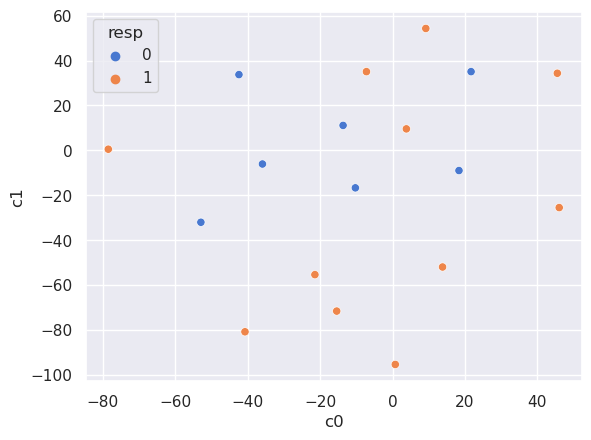

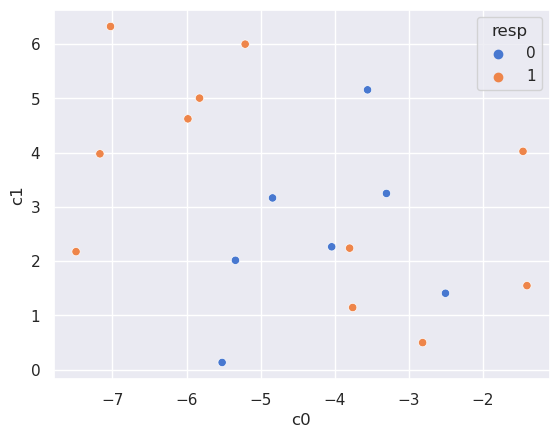

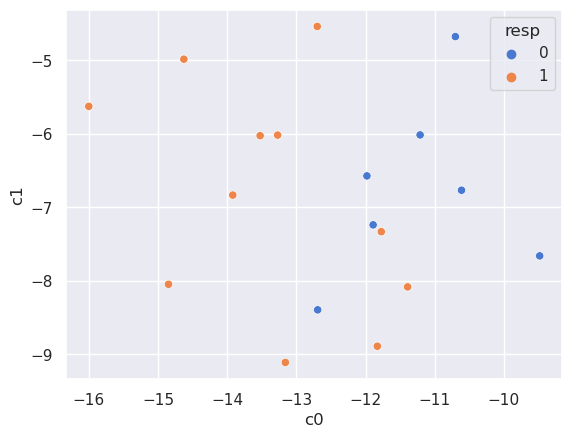

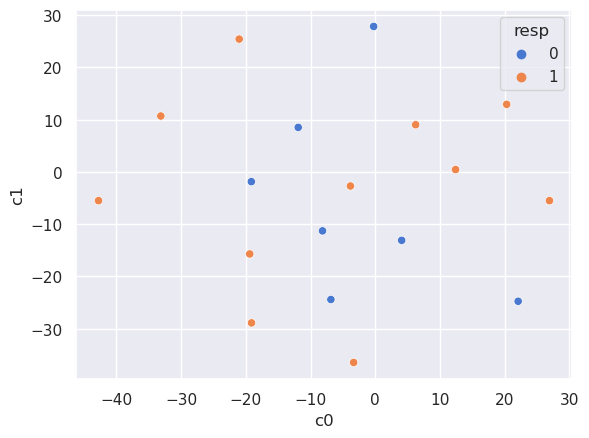

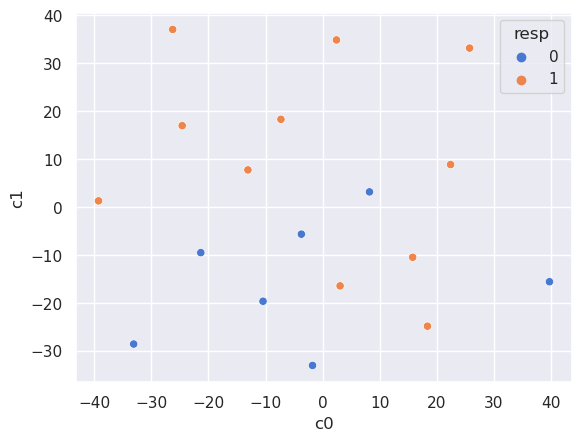

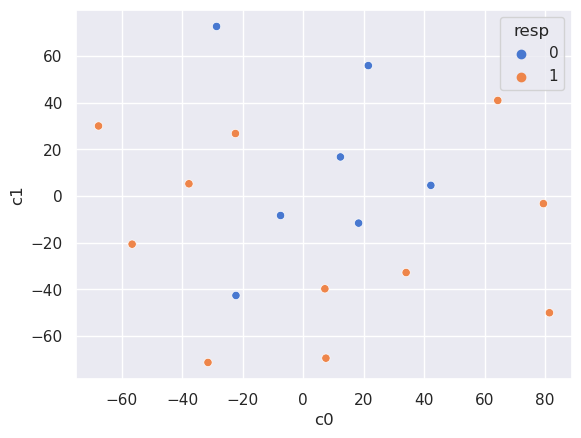

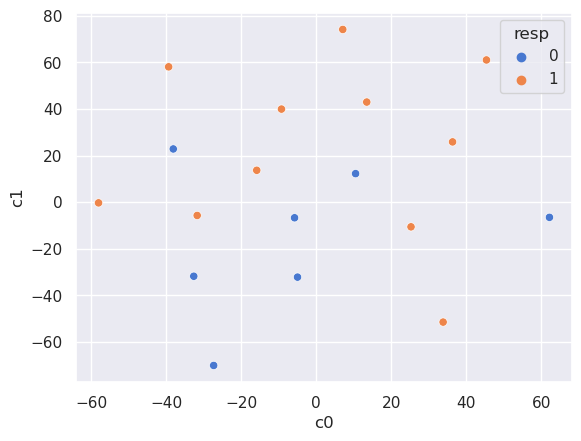

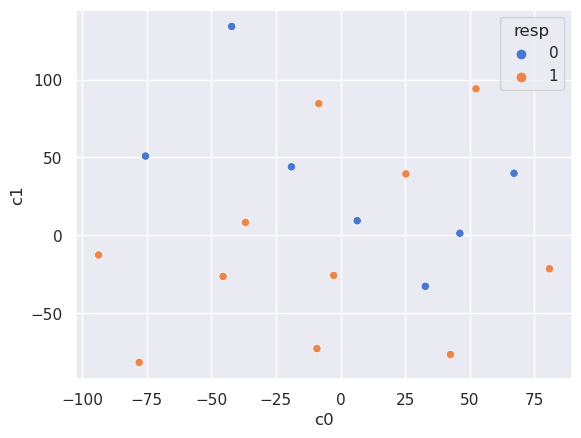

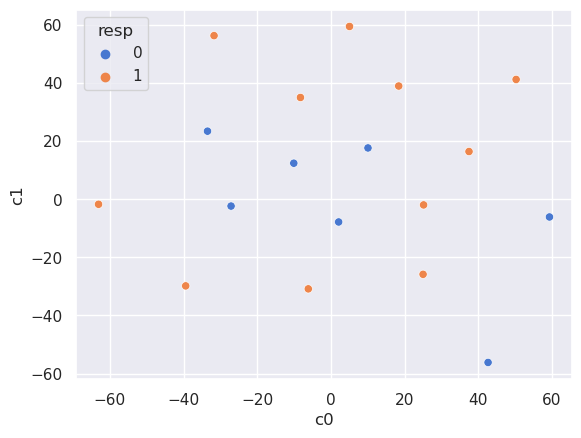

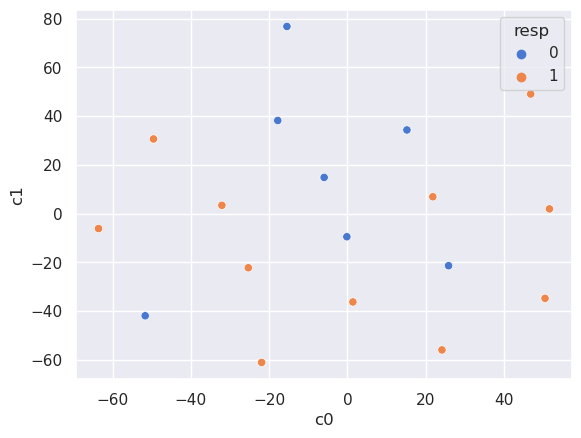

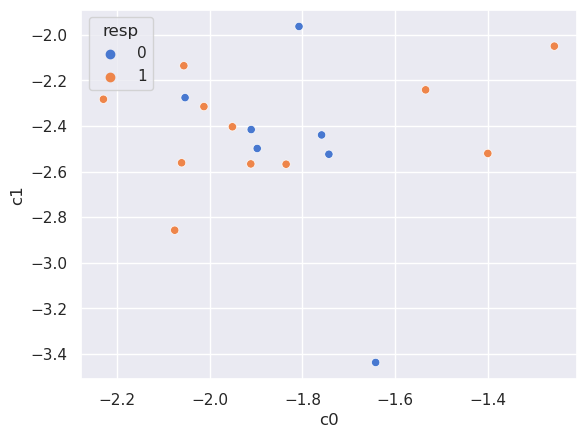

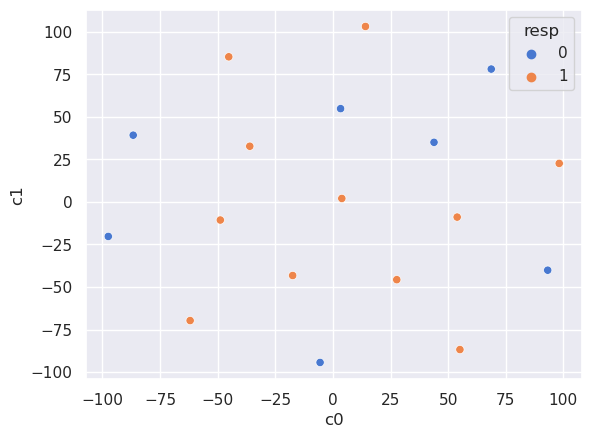

In [63]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

X = df

pca = PCA(
    n_components=2,
    svd_solver="full",
)
Y_pca = pd.DataFrame(pca.fit_transform(X), index=df.index, columns=["c0", "c1"])
Y_pca = pd.concat([Y_pca, df["resp"]], axis=1)

sns.scatterplot(Y_pca, x="c0", y="c1", hue="resp")

for perplexity in range(2, df.shape[0]):

    tSNE = TSNE(
        n_components=2,
        perplexity=perplexity, # to change
        learning_rate="auto", # epslon
        n_iter=5000, # per essere sicuro delle convergenza
        #n_iter_without_progress=3000, # per stopparlo prima
        init="pca",
        method="exact", # it's slowert but out dataset is small so we can affort it
        n_jobs=-1, # run in parallel
    )
    Y_tSNE = pd.DataFrame(tSNE.fit_transform(X),index=df.index, columns=["c0", "c1"])
    Y_tSNE = pd.concat([Y_tSNE, df["resp"]], axis=1)

    plt.figure()
    sns.scatterplot(Y_tSNE, x="c0", y="c1", hue="resp")

<Axes: xlabel='resp', ylabel='left-thalamus_odi_skew'>

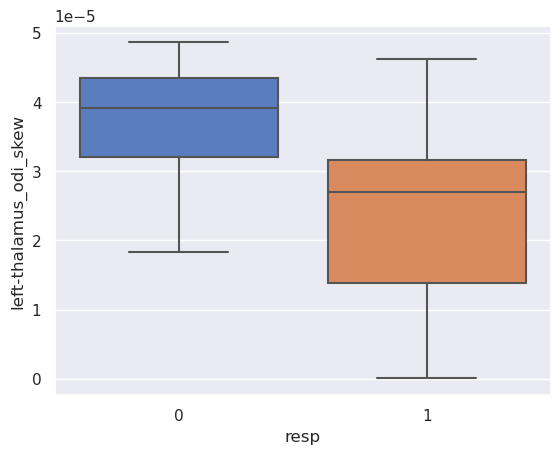

In [220]:
sns.boxplot(df_normalized, y='left-thalamus_odi_skew', x="resp")

<Axes: xlabel='resp', ylabel='left-thalamus_odi_skew'>

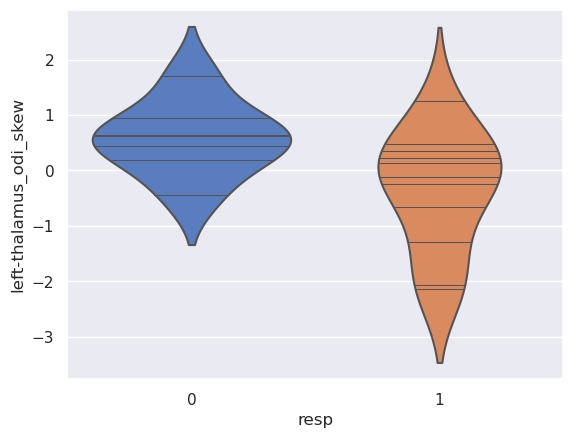

In [219]:
sns.violinplot(df_standardized, y="left-thalamus_odi_skew", x="resp", inner="stick")

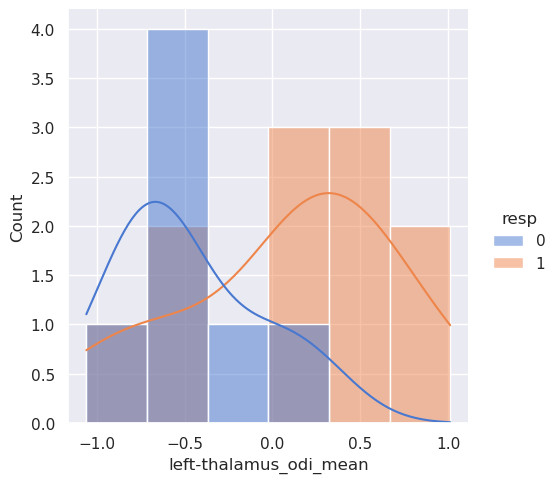

In [109]:
sns.displot(df, x="left-thalamus_odi_mean", hue="resp", kde=True)

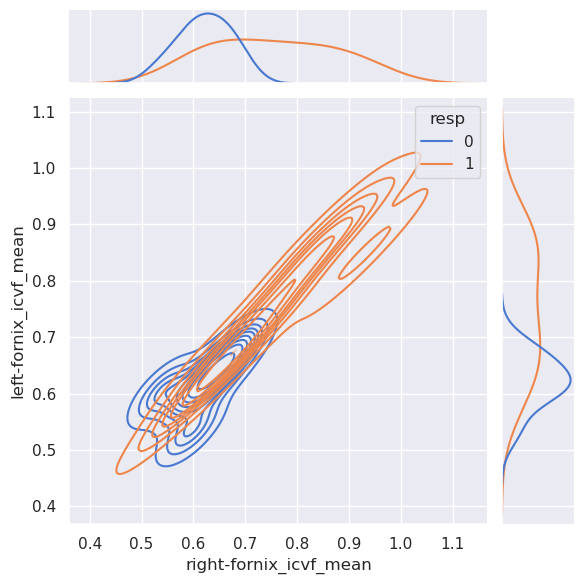

In [57]:
sns.jointplot(
    data=df,
    x='right-fornix_icvf_mean', y='left-fornix_icvf_mean', hue="resp",
    kind="kde"
)

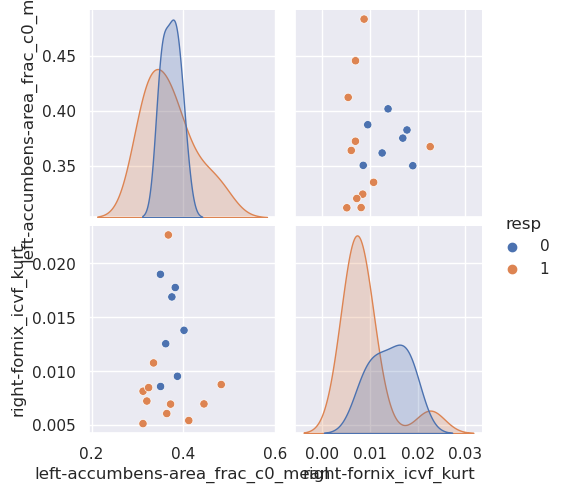

In [ ]:
toPlot = ['left-accumbens-area_frac_c0_mean', 'right-fornix_icvf_kurt']
sns.pairplot(df, hue="resp", x_vars=toPlot, y_vars=toPlot)

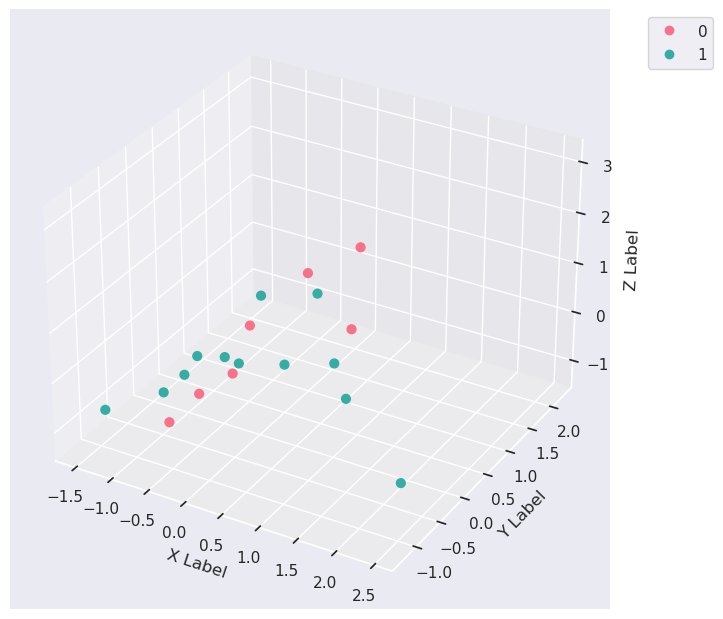

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

a = df
features = ['left-inf-longi-fasci_nTracts', 'left-thalamus-Insula_nTracts', 'right-inf-longi-fasci_nTracts']
x = a[features[0]]
y = a[features[1]]
z = a[features[2]]
labs = a["resp"]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 2).as_hex())

# plot
sc = ax.scatter(x, y, z, s=40, c=labs, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# Feature Weights

In [81]:
import eli5
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.pipeline import Pipeline

col_noskurt_noskew = df.filter(regex=r'mean|std').columns
col_noskurt_noskew = [*col_noskurt_noskew]

X_train, X_test, y_train, y_test = train_test_split(df[col_noskurt_noskew], df["resp"], test_size=1/3, random_state=7, shuffle=True, stratify=df["resp"])

clf = LogisticRegressionCV(
    cv=StratifiedShuffleSplit(n_splits=100, test_size=1/3, random_state=7),
    penalty="l2",
    n_jobs=-1,
    scoring="f1",
    solver="liblinear"
)

pipe = Pipeline([
    ("scaler", Normalizer()),
    ("clf", clf)
])

pipe.fit(X_train, y_train)

eli5.show_weights(clf, feature_names=col_noskurt_noskew, target_names=["nonResp", "resp"])

In [83]:
import shap
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import RobustScaler, Normalizer
from sklearn.pipeline import Pipeline

X_train, X_test, y_train, y_test = train_test_split(df[col_interest], df["resp"], test_size=1/3, random_state=7, shuffle=True, stratify=df["resp"])

clf = LogisticRegressionCV(
    cv=StratifiedShuffleSplit(n_splits=100, test_size=1/3, random_state=7),
    penalty="l2",
    n_jobs=-1,
    scoring="f1",
    solver="liblinear"
)

pipe = Pipeline([
    ("scaler", Normalizer()),
    ("clf", clf)
])

pipe.fit(X_train, y_train)

explainer = shap.Explainer(pipe.predict, X_test)
shap_values = explainer(X_train)

shap.plots.waterfall(shap_values)

ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 4093!

In [59]:
import shap
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df[col_interest], df["resp"], test_size=1/3, random_state=7, shuffle=True, stratify=df["resp"])

log_reg = SGDClassifier(loss = 'log_loss', n_jobs = -1, alpha = 1e-4, penalty="l2")
log_reg.fit(X_train, y_train)

explainer = shap.LinearExplainer(log_reg, X_train)
shap_values = explainer.shap_values(X_test)
shap.initjs()
ind = 0
shap.force_plot(explainer.expected_value, shap_values[ind,:], X_test.iloc[ind,:], feature_names = col_interest)

## Wrapper methods

### Forward

In [232]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

X = df_normalized.drop(["resp", "respPart"], axis=1)
y = df_normalized["resp"]

log_reg = SGDClassifier(loss = 'log_loss', n_jobs = -1, penalty = 'l2', max_iter=10000)

selector = SFS(
    log_reg,
    k_features=(2, 20),
    forward=True,
    floating=False, # da capire che significa
    scoring="f1",
    cv=StratifiedShuffleSplit(n_splits=1000, test_size=1/3, random_state=7),
    n_jobs=-1,
    verbose=2,   
)

selector = selector.fit(X, y)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   30.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.4min

STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

In [ ]:
print('Best accuracy score: %.2f' % selector.k_score_)
print('Best subset (indices):', selector.k_feature_idx_)
print('Best subset (corresponding names):', selector.k_feature_names_)

In [ ]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(selector.get_metric_dict(), kind='std_dev')

plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

### Backward

The Backward feature selection is not time feasible, because we would like to extract up to 20 features over about 1700

### Genetic

In [37]:
from myTransformers import GeneticSelection
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

sss = StratifiedShuffleSplit(n_splits=20, test_size=7)

clf = GradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.05,
    n_estimators=200,
    criterion="friedman_mse",
    max_depth=10,
    max_features=None, # Here I want to consider all the fetures, because the selectio is done by the algorithm
    warm_start=True,
    validation_fraction=0.2,
    n_iter_no_change=20,
    # there is even a ccp_alpha parameter, that can be usefull later
)

ga = GeneticSelection(clf, pop_size=100, scoring="roc_auc", cv=sss, n_jobs=-1)
ga.fit(X_train_p, y_train)

Size 100
Generation 0	Score 0.900000	
Selected Features
[[ True  True False False False False False  True  True  True  True  True
   True False False  True False False  True False  True False False  True
  False  True False False  True  True  True  True  True False  True False
   True  True  True False False  True  True False False False False False
  False False False False False  True  True False  True False  True False
   True False  True False  True  True False False  True False  True False
   True False  True  True False  True False  True False  True  True False
  False  True False False False  True False False False False  True False
   True False  True  True False  True False False  True False False False
  False  True False False  True False False False False  True  True False
   True  True False False False  True False False  True  True False False
   True False False False  True  True False  True  True  True False False
   True False False  True  True False  True  True False 

### Recoursive

In [334]:
from sklearn.feature_selection import RFECV
from sklearn import svm


clf = svm.LinearSVC(
    C=1e0,
    class_weight="balanced",
    dual=True
)

rfe = RFECV(
    estimator=clf_lin,
    step=1,
    scoring="roc_auc",
    cv=skf,
    min_features_to_select=2,
    n_jobs=-1
)

rfe.fit(X, y)
print(X.columns[rfe.get_support()].sort_values())


Index(['age', 'epilepsy_duration', 'epilepsy_onset_age',
       'left-accumbens-area_fvf_f1_kurt', 'left-accumbens-area_fvf_f1_skew',
       'left-accumbens-area_fvf_f1_std', 'left-fornix_MD_mean',
       'left-fornix_RD_mean', 'left-hippocampus_fbundle_skew',
       'left-hippocampus_fintra_mean', 'left-hippocampus_fiso_skew',
       'left-thalamus-AntCingCtx_MD_mean',
       'left-thalamus-AntCingCtx_fvf_f1_mean',
       'left-thalamus-AntCingCtx_fvf_f1_std', 'left-thalamus-proper_AD_mean',
       'left-thalamus-proper_MD_mean', 'right-accumbens-area_fvf_f1_kurt',
       'right-accumbens-area_fvf_f1_skew', 'right-amygdala_frac_c0_skew',
       'right-fornix_MD_kurt', 'right-fornix_MD_mean', 'right-fornix_RD_mean',
       'right-fornix_fintra_mean', 'right-fornix_fvf_tot_mean',
       'right-inf-longi-fasci_odi_kurt', 'right-inf-longi-fasci_odi_skew',
       'right-thalamus-Insula_AD_mean', 'right-thalamus-Insula_MD_mean',
       'right-thalamus-Insula_fintra_mean', 'right-thalamus-pr

,rank
age,1
right-accumbens-area_fvf_f1_kurt,1


## Embedded methods

### From model

In [351]:
from sklearn.feature_selection import SelectFromModel

X = df_mean.drop(["resp","respPart"], axis=1)
y = df_mean["resp"]

clf = svm.LinearSVC(
    C=1e-2,
    class_weight="balanced",
    dual=True
)

frModel = SelectFromModel(
    estimator=clf,
    max_features=20,
)

frModel.fit(X, y)
print(X.columns[frModel.get_support()].sort_values())

pd.DataFrame(abs(frModel.estimator_.coef_.T), index=X.columns, columns=["rank"]).sort_values("rank", ascending=False)[:20]

Index(['age', 'epilepsy_duration', 'epilepsy_onset_age',
       'left-accumbens-area_fvf_f1_kurt', 'left-fornix_RD_mean',
       'left-fornix_fextra_std', 'left-inf-longi-fasci_fvf_f0_kurt',
       'right-accumbens-area_fvf_f1_skew', 'right-fornix_RD_mean',
       'right-fornix_fextra_kurt', 'right-fornix_fintra_kurt',
       'right-fornix_fintra_mean', 'right-fornix_fintra_std',
       'right-fornix_frac_c0_std', 'right-fornix_fvf_tot_kurt',
       'right-fornix_fvf_tot_mean', 'right-fornix_fvf_tot_skew',
       'right-fornix_wFA_kurt', 'right-thalamus-Insula_fintra_skew',
       'right-thalamus-proper_fintra_skew'],
      dtype='object')


,rank
epilepsy_onset_age,0.018317
age,0.012354
epilepsy_duration,0.010062
right-thalamus-proper_fintra_skew,0.008841
right-fornix_fintra_mean,0.008535
right-fornix_fvf_tot_kurt,0.007816
right-fornix_fextra_kurt,0.007704
right-thalamus-Insula_fintra_skew,0.007654
right-fornix_fintra_kurt,0.007557
right-fornix_fvf_tot_skew,0.007369


# Model Selection

In this first analysis we consider a binary classification problem. Therefore, we keep the NR-RP/R labels, in which the Partial responders are considered as Responders.

*In next analysis we will consider a multiclass classification problem, trying to classify all the three different types* 

In [376]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold, RFECV, SelectKBest, f_classif, mutual_info_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression, ElasticNet, LinearRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

y = df["resp"]
X = df.drop(["resp", "respPart"], axis=1) 

models = {
    "linearSVM" : (
        LinearSVC(), 
        {
            "selection__k" : (2, 3, 5, 7, 9),
            "classifier__C" : (1e-3, 1e-2, 1e-1),
        }
    ),
    "SVM" : (
        SVC(),
        [
            {
                "selection__k" : (2, 3, 5, 7, 9),
                "classifier__C" :(1e-3, 1e-2, 1e-1, 1),
                "classifier__kernel" : ['linear'], 
            },
            {
                "selection__k" : (2, 3, 5, 7, 9),
                "classifier__C" :(1e-3, 1e-2, 1e-1, 1),
                "classifier__kernel" : ['poly'],
                "classifier__degree" : (2, 3, 4),
            },
            {
                "selection__k" : (2, 3, 5, 7, 9),
                "classifier__C" :(1e-3, 1e-2, 1e-1, 1),
                "classifier__kernel" : ['rbf'], 
                "classifier__gamma" : (1e-3, 1e-2, 1e-1, 1),
            },
        ]
    ),
    "LogReg" : (
        LogisticRegression(),
        {
            "selection__k" : (2, 3, 5, 7, 9),
            "classifier__penalty" : ["l2"],
            "classifier__dual" : [True],
            "classifier__C" :(1e-3, 1e-2, 1e-1),
        },
    ),
    "LinReg" : (
        LinearRegression(),
        {
            "selection__k" : (2, 3, 5, 7, 9),
        }
    ),
    "ridgeReg" : (
        RidgeClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9),
            "classifier__alpha" : (0.5, 1, 5, 10, 20, 40)
        }
    ),
    "elasticNet" : (
        ElasticNet(),
        {
            "selection__k" : (2, 3, 5, 7, 9),
            "classifier__alpha" : (0.5, 1, 5, 10, 20, 40),  # 0 == Linear Regression
            "classifier__l1_ratio" : (0.5, 1), # 0 == Ridge Regression, 1 == Lasso Regression
        },
    ),
    "neighbors" : (
        KNeighborsClassifier(),
        {
            "selection__k" : (2, 3, 5, 7, 9),
            "classifier__n_neighbors" : (2, 3, 5),
            "classifier__weights" : ("uniform", "distance"),
        }
    ),
    "gaussianNaive" : (
        GaussianNB(),
        {
            "varThres__threshold" : (0.25, 0.5, 0.75, 1),
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17, 19, 21),
        }
    ),
    "tree" : (
        DecisionTreeClassifier(),
        {
            "varThres__threshold" : (0.25, 0.5, 0.75, 1),
            "selection__k" : (2, 3, 5, 7, 9),
            "classifier__criterion" : ("gini", "entropy", "log_loss")
        }
    ),
    "forest" : (
        RandomForestClassifier(),
        {
            "varThres__threshold" : (0.25, 0.5, 0.75, 1),
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17),
            "classifier__n_estimators" : (100, 500, 1000),
            # Check if make sense choose also the criterion (see the tree)
            "classifier__max_samples" : [0.5]
        }
    ),
    "extraForest" : (
        ExtraTreesClassifier(),
        {
            "varThres__threshold" : (0.25, 0.5, 0.75, 1),
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17),
            "classifier__n_estimators" : (100, 500, 1000),
            # Check if make sense choose also the criterion (see the tree)
            "classifier__bootstrap" : [True],
            "classifier__max_samples" : [0.5],
        }
    ),
    "adaBoost" : (
        AdaBoostClassifier(),
        {
            "varThres__threshold" : (0.25, 0.5, 0.75, 1),
            "selection__k" : (2, 3, 5, 7, 9, 11, 13, 17),
            "classifier__n_estimators" : (100, 1000),
        }
    )
}

skf = StratifiedKFold(n_splits=5, shuffle=True)

fitted_models = {}

for modelName, (classifier, grid) in models.items():

    pre = ColumnTransformer(
            [("scaling", RobustScaler(), col_cont)],
            remainder="passthrough", # one hot or other stuff
        )
    
    thresh = VarianceThreshold()
    
    imputer = SimpleImputer(
            missing_values=np.nan, 
            strategy="mean"
        )
    
    selection = SelectKBest(
            score_func=mutual_info_classif,
        )
    
    pipe = Pipeline([
        ("pre", pre),
        ("varThres", thresh),
        ("imputer", imputer),
        ("selection", selection),
        ("classifier", classifier)
    ])

    model = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="roc_auc",
        n_jobs=-1,
        cv=skf,
        verbose=3
    )

    model.fit(X, y)
    fitted_models[modelName] = model

    print(modelName, "score:", model.best_score_)
    print(model.best_params_) 

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END classifier__C=0.001, selection__k=2;, score=0.333 total time=   5.5s
[CV 4/5] END classifier__C=0.001, selection__k=2;, score=0.500 total time=   5.4s
[CV 1/5] END classifier__C=0.001, selection__k=3;, score=0.333 total time=   5.8s
[CV 3/5] END classifier__C=0.001, selection__k=3;, score=0.000 total time=   5.5s
[CV 3/5] END classifier__C=0.001, selection__k=2;, score=0.250 total time=   6.0s
[CV 5/5] END classifier__C=0.001, selection__k=2;, score=0.000 total time=   5.9s
[CV 2/5] END classifier__C=0.001, selection__k=3;, score=0.000 total time=   5.5s
[CV 2/5] END classifier__C=0.001, selection__k=2;, score=0.000 total time=   6.3s
[CV 4/5] END classifier__C=0.001, selection__k=3;, score=0.500 total time=   6.3s
[CV 2/5] END classifier__C=0.001, selection__k=5;, score=0.333 total time=   5.6s
[CV 5/5] END classifier__C=0.001, selection__k=3;, score=0.000 total time=   6.5s
[CV 1/5] END classifier__C=0.001, se

/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END classifier__C=100.0, selection__k=2;, score=0.000 total time=   5.9s
[CV 5/5] END classifier__C=10.0, selection__k=9;, score=0.000 total time=   6.4s
[CV 3/5] END classifier__C=100.0, selection__k=2;, score=0.000 total time=   6.3s
[CV 1/5] END classifier__C=100.0, selection__k=2;, score=0.333 total time=   7.4s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END classifier__C=100.0, selection__k=2;, score=1.000 total time=   6.6s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END classifier__C=100.0, selection__k=2;, score=0.000 total time=   6.7s
[CV 1/5] END classifier__C=100.0, selection__k=3;, score=0.333 total time=   6.6s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END classifier__C=100.0, selection__k=3;, score=0.000 total time=   7.1s
[CV 3/5] END classifier__C=100.0, selection__k=3;, score=0.500 total time=   6.8s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END classifier__C=100.0, selection__k=3;, score=0.500 total time=   7.1s
[CV 1/5] END classifier__C=100.0, selection__k=5;, score=0.333 total time=   6.6s
[CV 2/5] END classifier__C=100.0, selection__k=5;, score=0.000 total time=   6.4s
[CV 5/5] END classifier__C=100.0, selection__k=3;, score=0.000 total time=   7.2s
[CV 3/5] END classifier__C=100.0, selection__k=5;, score=0.500 total time=   7.0s
[CV 4/5] END classifier__C=100.0, selection__k=5;, score=0.500 total time=   6.7s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END classifier__C=100.0, selection__k=5;, score=0.000 total time=   7.2s
[CV 3/5] END classifier__C=100.0, selection__k=7;, score=0.250 total time=   6.0s
[CV 2/5] END classifier__C=100.0, selection__k=7;, score=0.000 total time=   7.0s
[CV 1/5] END classifier__C=100.0, selection__k=7;, score=0.333 total time=   7.6s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END classifier__C=100.0, selection__k=7;, score=0.500 total time=   7.1s
[CV 5/5] END classifier__C=100.0, selection__k=7;, score=0.500 total time=   7.4s
[CV 2/5] END classifier__C=100.0, selection__k=9;, score=0.000 total time=   6.7s
[CV 1/5] END classifier__C=100.0, selection__k=9;, score=0.667 total time=   7.6s
[CV 3/5] END classifier__C=100.0, selection__k=9;, score=0.250 total time=   6.7s
[CV 1/5] END classifier__C=1000.0, selection__k=2;, score=0.333 total time=   5.8s
[CV 4/5] END classifier__C=100.0, selection__k=9;, score=0.500 total time=   7.0s
[CV 5/5] END classifier__C=100.0, selection__k=9;, score=0.000 total time=   7.0s
[CV 2/5] END classifier__C=1000.0, selection__k=2;, score=0.000 total time=   7.9s
[CV 3/5] END classifier__C=1000.0, selection__k=2;, score=0.250 total time=   7.4s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END classifier__C=1000.0, selection__k=2;, score=0.500 total time=   6.7s
[CV 2/5] END classifier__C=1000.0, selection__k=3;, score=0.000 total time=   5.9s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END classifier__C=1000.0, selection__k=2;, score=0.000 total time=   7.2s
[CV 1/5] END classifier__C=1000.0, selection__k=3;, score=0.333 total time=   7.5s
[CV 3/5] END classifier__C=1000.0, selection__k=3;, score=0.000 total time=   6.6s


/home/michele/anaconda3/envs/dMRI/lib/python3.9/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END classifier__C=1000.0, selection__k=3;, score=0.500 total time=   6.7s
[CV 1/5] END classifier__C=1000.0, selection__k=5;, score=0.333 total time=   6.6s
[CV 5/5] END classifier__C=1000.0, selection__k=3;, score=0.000 total time=   7.3s
[CV 2/5] END classifier__C=1000.0, selection__k=5;, score=0.000 total time=   6.1s
[CV 3/5] END classifier__C=1000.0, selection__k=5;, score=0.250 total time=   6.0s
[CV 4/5] END classifier__C=1000.0, selection__k=5;, score=0.000 total time=   6.3s
[CV 1/5] END classifier__C=1000.0, selection__k=7;, score=0.667 total time=   6.5s
[CV 5/5] END classifier__C=1000.0, selection__k=5;, score=0.000 total time=   6.6s
[CV 2/5] END classifier__C=1000.0, selection__k=7;, score=0.333 total time=   6.7s
[CV 3/5] END classifier__C=1000.0, selection__k=7;, score=0.500 total time=   6.5s
[CV 4/5] END classifier__C=1000.0, selection__k=7;, score=0.500 total time=   6.4s
[CV 5/5] END classifier__C=1000.0, selection__k=7;, score=0.000 total time=   6.3s
[CV 

KeyboardInterrupt: 